# 몬테 카를로 tic-tac-toe agent

In [23]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [24]:
GOING_FIRST = 1
GOING_SECOND = -1
EMPTY_TILE = 0

RENDERING_SYMBOL = {GOING_FIRST : 'O', GOING_SECOND : 'X', EMPTY_TILE : '-'}

BOARD_ROWS = 3
BOARD_COLS = 3

In [25]:
'''
Action Index for each position

(0,0) : 0, (0,1) : 1, (0,2) : 2,
(1,0) : 3, (1,1) : 4, (1,2) : 5,
(2,0) : 6, (2,1) : 7, (2,2) : 8
'''
def pos_to_actidx(row_idx, col_idx):
    action_idx = -1
    if 0 <= row_idx < BOARD_ROWS and 0 <= col_idx < BOARD_COLS:
        action_idx = 3*row_idx + col_idx
    return action_idx

In [26]:
class State:
    def __init__(self, board_rows=BOARD_ROWS, board_cols=BOARD_COLS):
        self.board_rows = board_rows
        self.board_cols = board_cols
        self.board_size = board_rows * board_cols

        self.board = np.zeros(shape=[board_rows, board_cols], dtype=int) # 3X3 게임판 초기 상태

        self.empty_tile = EMPTY_TILE # 0
        self.going_first = GOING_FIRST # 1
        self.going_second = GOING_SECOND # -1

        self.rendering_symbol = RENDERING_SYMBOL

        self.winner = 0
        self.end = False

    # 가능한 액션 인덱스를 반환하는 함수 (수를 둘 수 있는 위치가 어딘지 알려주는 함수)
    def get_available_actions(self):
        if self.is_end_state():
            return []

        available_positions = np.argwhere(self.board == self.empty_tile)

        available_action_ids = [pos_to_actidx(pos[0], pos[1]) for pos in available_positions]

        return available_action_ids

    # 게임 종료 여부
    def is_end_state(self):
        if self.end:
            return self.end

        row_sums = np.sum(self.board, axis=1)  # 각 행의 합
        col_sums = np.sum(self.board, axis=0)  # 각 열의 합

        # 대각선의 합
        trace = np.trace(self.board)  # 왼쪽 위 ~ 오른쪽 아래로
        reverse_trace = np.trace(np.fliplr(self.board))  # 오른쪽 위 ~ 왼쪽 아래
        ## np.fliplr()
        ## [[1 2 3]  --->  [[3 2 1]
        ##  [4 5 6]         [6 5 4]
        ##  [7 8 9]]        [9 8 7]]

        results = np.concatenate((row_sums, col_sums, [trace, reverse_trace]))

        # GOING_FIRST(선공) 또는 GOING_SECOND(후공) 승리 조건 확인
        for result in results:
            if result == 3 or result == -3:
                self.end = True
                if result == 3:
                    self.winner = self.going_first
                else:
                    self.winner = self.going_second
                return self.end

        # 무승부 확인: 모든 칸이 채워졌는지 확인 (보드의 절댓값의 합이 총 칸 수와 같다면 무승부)
        if np.sum(np.abs(self.board)) == self.board_size:
            self.winner = 0
            self.end = True
            return self.end

        # 게임이 아직 끝나지 않음
        self.end = False
        return self.end

    def get_winner(self):
        if self.winner == self.going_first:
            return 1
        elif self.winner == self.going_second:
            return -1
        else:
            return 0

    # render 함수
    def get_state_as_board(self):
        int_to_symbol = np.where(self.board == 1, 'O',
                                np.where(self.board == -1, 'X', '-'))

        rendering_board = '\n'.join([' '.join(row) for row in int_to_symbol])

        return rendering_board

In [27]:
class TicTacToeEnv:
    def __init__(self, agent1, agent2):
        self.state = State()
        self.agent1 = agent1
        self.agent2 = agent2
        self.current_turn = self.state.going_first  # 선공부터 시작

        self.action_space = np.arange(self.state.board_size)
        self.num_actions = len(self.action_space)

        self.reward_dict = {'win': 10, 'lose': -10, 'draw': 0, 'continue': 0}

    def reset(self):
        self.state = State()
        self.current_turn = self.state.going_first
        return self.state

    def step(self, action):
        if self.current_turn == self.state.going_first:
            agent_role = self.state.going_first
            agent = self.agent1
        else:
            agent_role = self.state.going_second
            agent = self.agent2

        # 행동 적용
        x, y = np.divmod(action, self.state.board_cols)
        if self.state.board[x, y] != self.state.empty_tile:
            raise ValueError(f"Invalid action: Tile ({x}, {y}) is already occupied.")

        self.state.board[x, y] = agent_role

        # 상태 업데이트
        self.state.end = self.state.is_end_state()

        # 턴 교대
        self.current_turn = self.state.going_second if self.current_turn == self.state.going_first else self.state.going_first

        # 보상 및 종료 여부 반환
        if self.state.end:
            if self.state.winner == self.state.going_first:
                reward = self.reward_dict['win'] if agent_role == self.state.going_first else self.reward_dict['lose']
                done = True
                result = 'agent1 wins' if agent_role == self.state.going_first else 'agent2 wins'
            elif self.state.winner == self.state.going_second:
                reward = self.reward_dict['win'] if agent_role == self.state.going_second else self.reward_dict['lose']
                done = True
                result = 'agent2 wins' if agent_role == self.state.going_second else 'agent1 wins'
            else:
                reward = self.reward_dict['draw']
                done = True
                result = 'draw'
        else:
            reward = self.reward_dict['continue']
            done = False
            result = 'continue'

        return self.state, reward, done, result

    def render(self):
        return self.state.get_state_as_board()

In [28]:
class MonteCarloAgent:
    def __init__(self, role, epsilon=0.1, discount_factor=0.9):
        self.role = role  # GOING_FIRST(1) 또는 GOING_SECOND(-1)
        self.epsilon = epsilon
        self.discount_factor = discount_factor
        self.state_action_values = {}  # (상태, 행동) : 큐함수 값
        self.state_action_returns = {}  # (상태, 행동) : 반환값
        self.state_action_counts = {}  # (상태, 행동) : 방문 횟수

    def get_action(self, state):
        available_actions = state.get_available_actions()

        # 탐험
        if np.random.rand() < self.epsilon:
            return random.choice(available_actions)

        # 활용: 탐욕 정책을 따름
        state_tuple = tuple(state.board.flatten())
        action_values = [self.state_action_values.get((state_tuple, action), 0) for action in available_actions]

        # 가장 높은 큐함수 값을 가지는 행동 선택
        best_action = available_actions[np.argmax(action_values)]
        return best_action

    def update_values(self, episode):
        """
        episode: [(state, action, reward), ..., (state, action, reward)]
        게임 종료 후 각 상태-행동 쌍에 대한 가치를 업데이트
        """
        G = 0  # 반환값
        visited_state_actions = set()  # 중복 업데이트 방지

        # 에피소드 역순으로 진행
        for state, action, reward in reversed(episode):
            state_tuple = tuple(state.board.flatten())
            G = self.discount_factor * G + reward

            if (state_tuple, action) not in visited_state_actions:
                # 상태-행동 쌍 방문 기록
                visited_state_actions.add((state_tuple, action))

                # 첫 방문 몬테 카를로 방식으로 상태-행동 쌍의 가치 업데이트
                if (state_tuple, action) not in self.state_action_values:
                    self.state_action_values[(state_tuple, action)] = 0
                    self.state_action_counts[(state_tuple, action)] = 0
                    self.state_action_returns[(state_tuple, action)] = []

                # 상태-행동 쌍에 대한 평균 리턴 값 업데이트
                self.state_action_counts[(state_tuple, action)] += 1
                self.state_action_values[(state_tuple, action)] += (G - self.state_action_values[(state_tuple, action)]) / self.state_action_counts[(state_tuple, action)]

Game 500: Visualizing state-action values for agent1


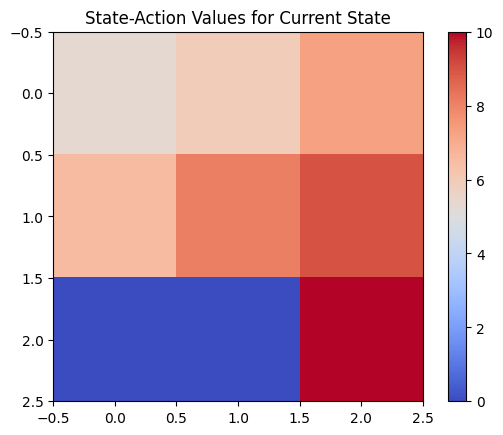

Game 1000: Visualizing state-action values for agent1


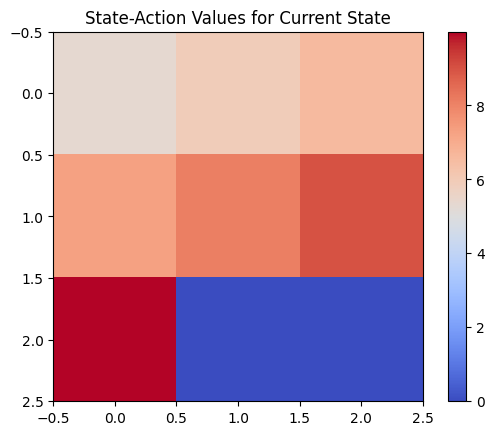

Game 1500: Visualizing state-action values for agent1


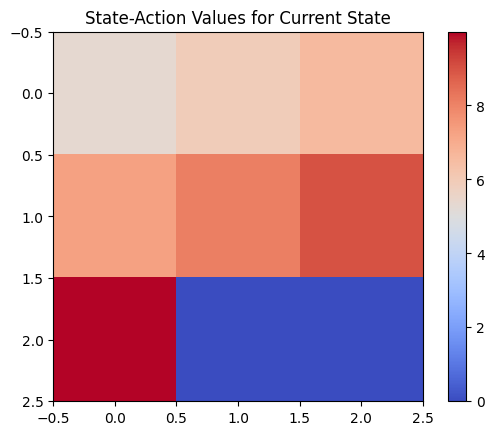

Game 2000: Visualizing state-action values for agent1


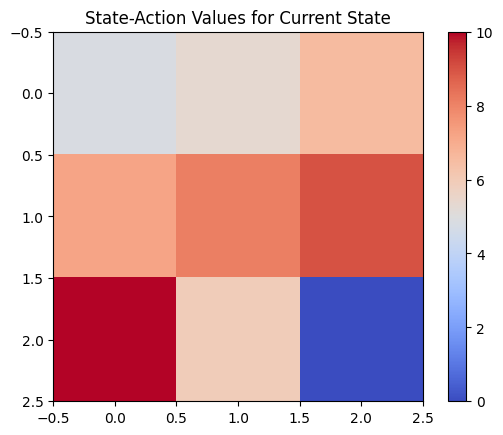

Game 2500: Visualizing state-action values for agent1


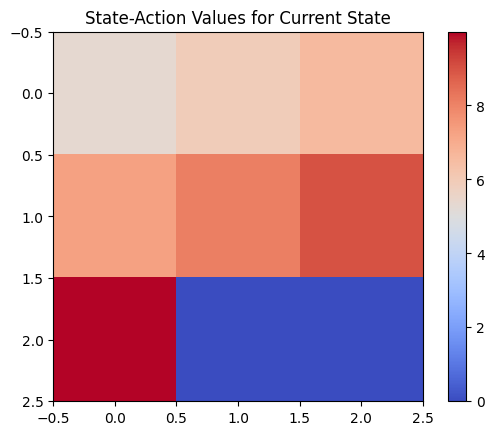

Game 3000: Visualizing state-action values for agent1


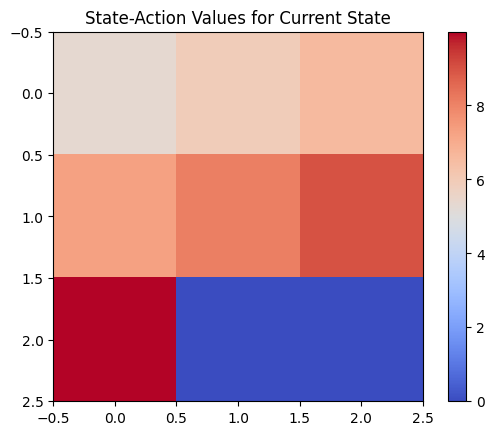

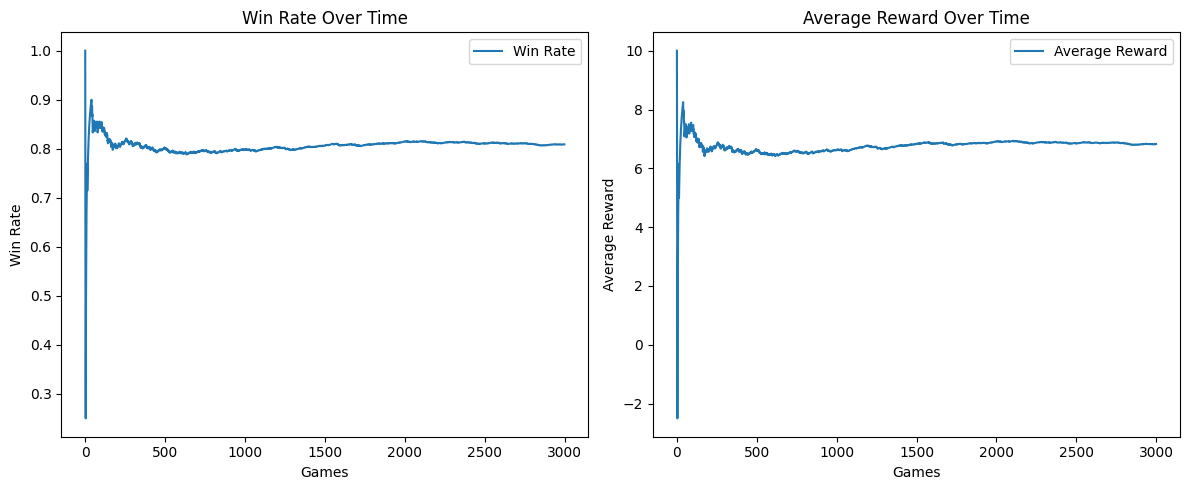

In [29]:
def play_game(env: TicTacToeEnv, agent1: MonteCarloAgent, agent2: MonteCarloAgent, render: bool=True):
    """
    게임을 플레이하고, 각 에이전트는 자신의 경험을 업데이트
    """
    state = env.reset()
    episode = []

    while True:
        if env.current_turn == env.state.going_first:
            action = agent1.get_action(state)
            agent = agent1
        else:
            action = agent2.get_action(state)
            agent = agent2

        state, reward, done, result = env.step(action)

        # 현재 상태, 선택된 행동, 즉시 보상을 기록
        episode.append((state, action, reward))

        if render:
            print(state.get_state_as_board())
            print(result)
            print("-" * 10)

        if done:
            break

    # 에피소드 종료 후 가치 업데이트
    agent1.update_values(episode)
    agent2.update_values(episode)

# 승률 및 평균 보상 시각화 함수
def plot_metrics(win_rates, avg_rewards):
    plt.figure(figsize=(12, 5))

    # 승률 변화
    plt.subplot(1, 2, 1)
    plt.plot(win_rates, label="Win Rate")
    plt.xlabel('Games')
    plt.ylabel('Win Rate')
    plt.title('Win Rate Over Time')
    plt.legend()

    # 평균 보상 변화
    plt.subplot(1, 2, 2)
    plt.plot(avg_rewards, label="Average Reward")
    plt.xlabel('Games')
    plt.ylabel('Average Reward')
    plt.title('Average Reward Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 상태-행동 가치 시각화 함수
def visualize_state_action_values(agent, state):
    state_tuple = tuple(state.board.flatten())

    # 현재 상태에서 가능한 모든 행동의 가치를 시각화
    action_values = [agent.state_action_values.get((state_tuple, action), 0) for action in range(state.board_size)]
    action_values = np.array(action_values).reshape(state.board_rows, state.board_cols)

    plt.imshow(action_values, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    plt.title('State-Action Values for Current State')
    plt.show()


### Main ###

agent1 = MonteCarloAgent(role=GOING_FIRST)
agent2 = MonteCarloAgent(role=GOING_SECOND)
env = TicTacToeEnv(agent1, agent2)

win_rates = []         # 승률 기록
avg_rewards = []       # 평균 보상 기록
total_wins = 0         # 총 승리 횟수
total_rewards = 0      # 총 보상
num_games = 1000       # 게임 횟수

# 여러 게임 반복
num_games = 3000
for i in range(num_games):
    # 게임 진행
    play_game(env, agent1, agent2, render=False)

    # 역할 교대
    env.agent1, env.agent2 = env.agent2, env.agent1
    env.agent1.role, env.agent2.role = env.agent2.role, env.agent1.role

    # 승리 횟수 기록 (agent1이 GOING_FIRST로 시작하므로 해당 에이전트의 승리 기록)
    if env.state.winner == GOING_FIRST:
        total_wins += 1

    # 보상 기록 (승리, 패배, 무승부에 따른 보상 업데이트)
    if env.state.winner == GOING_FIRST:
        total_rewards += env.reward_dict['win']
    elif env.state.winner == GOING_SECOND:
        total_rewards += env.reward_dict['lose']
    else:
        total_rewards += env.reward_dict['draw']

    # 현재까지의 승률 및 평균 보상 계산
    win_rates.append(total_wins / (i + 1))  # 승률 업데이트
    avg_rewards.append(total_rewards / (i + 1))  # 평균 보상 업데이트

    # 100번째 게임마다 상태-행동 가치 시각화
    if (i + 1) % 500 == 0:
        print(f"Game {i + 1}: Visualizing state-action values for agent1")
        visualize_state_action_values(agent1, env.state)

# 최종 시각화
plot_metrics(win_rates, avg_rewards)

In [30]:
env.reset()

play_game(env, agent1, agent2, render=True)

O - -
- - -
- - -
continue
----------
O X -
- - -
- - -
continue
----------
O X O
- - -
- - -
continue
----------
O X O
X - -
- - -
continue
----------
O X O
X O -
- - -
continue
----------
O X O
X O X
- - -
continue
----------
O X O
X O X
O - -
agent1 wins
----------
